In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import ReconstructionLoss, TemporalLoss, SingleVisLoss, DummyTemporalLoss
from singleVis.backend import convert_distance_to_probability, compute_cross_entropy
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import BaseTextTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import SingleEpochTextSpatialEdgeConstructor

from singleVis.projector import VISProjector
from singleVis.utils import find_neighbor_preserving_rate

/home/yiming/anaconda3/envs/visualizer/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch import nn
class UmapLoss(nn.Module):
    def __init__(self, negative_sample_rate, device, _a=1.0, _b=1.0, repulsion_strength=1.0):
        super(UmapLoss, self).__init__()

        self._negative_sample_rate = negative_sample_rate
        self._a = _a,
        self._b = _b,
        self._repulsion_strength = repulsion_strength
        self.DEVICE = torch.device(device)

    @property
    def a(self):
        return self._a[0]

    @property
    def b(self):
        return self._b[0]

    def forward(self, embedding_to, embedding_from, probs):
        # get negative samples
        batch_size = embedding_to.shape[0]
        embedding_neg_to = torch.repeat_interleave(embedding_to, self._negative_sample_rate, dim=0)
        repeat_neg = torch.repeat_interleave(embedding_from, self._negative_sample_rate, dim=0)
        randperm = torch.randperm(repeat_neg.shape[0])
        embedding_neg_from = repeat_neg[randperm]
        neg_num = len(embedding_neg_from)

        positive_distance = torch.norm(embedding_to - embedding_from, dim=1)
        negative_distance = torch.norm(embedding_neg_to - embedding_neg_from, dim=1)

        distance_embedding = torch.cat(
            (
                positive_distance,
                negative_distance,
            ),
            dim=0,
        )
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, self.a, self.b
        )
        probabilities_distance = probabilities_distance.to(self.DEVICE)

        probabilities_graph = torch.cat(
            (torch.ones(batch_size).to(self.DEVICE), torch.zeros(neg_num).to(self.DEVICE)), dim=0,
        )

        # probabilities_graph = torch.cat(
        #     (probs.to(self.DEVICE), torch.zeros(neg_num).to(self.DEVICE)), dim=0,
        # )

        probabilities_graph = probabilities_graph.to(device=self.DEVICE)

        # compute cross entropy
        (_, _, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=self._repulsion_strength,
        )   

        return torch.mean(ce_loss)

class DVILoss(nn.Module):
    def __init__(self, umap_loss, recon_loss, temporal_loss, lambd1, lambd2, device):
        super(DVILoss, self).__init__()
        self.umap_loss = umap_loss
        self.recon_loss = recon_loss
        self.temporal_loss = temporal_loss
        self.lambd1 = lambd1
        self.lambd2 = lambd2
        self.device = device

    def forward(self, edge_to, edge_from, a_to, a_from, curr_model,probs):
      
        outputs = curr_model( edge_to, edge_from)
        embedding_to, embedding_from = outputs["umap"]
        recon_to, recon_from = outputs["recon"]

        recon_l = self.recon_loss(edge_to, edge_from, recon_to, recon_from, a_to, a_from).to(self.device)
        umap_l = self.umap_loss(embedding_to, embedding_from, probs)
        temporal_l = self.temporal_loss(curr_model).to(self.device)

        loss = umap_l + self.lambd1 * recon_l + self.lambd2 * temporal_l

        return umap_l, umap_l, self.lambd1 *recon_l, self.lambd2 *temporal_l, loss

In [4]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [5]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [6]:
import json
def load_loss_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return np.array(data)

In [7]:

valid_code_path = "/home/yiming/cophi/projects/fork/CoSQA_Plus/datasetBuild/dataset/gpt4o_augment_codebase_process.json"
code_dataset = []
with open(valid_code_path, "r") as f:
    try:
        code_dataset = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error parsing line in {valid_code_path}: {e}")

# 读取test_query_process.json文件 
test_query_path = "/home/yiming/cophi/projects/fork/CoSQA_Plus/datasetBuild/dataset/test_query_process.json"
comment_dataset = []
with open(test_query_path, "r") as f:
    try:
        comment_dataset = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error parsing {test_query_path}: {e}")

In [8]:
import json
import os

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls_cosqa/cosqa_tokenized_code_tokens.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    code_tokens_data = json.load(f)

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs_cls_cosqa/cosqa_tokenized_nl_tokens.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    nl_tokens_data = json.load(f)

In [9]:
data_ind = 0
convert_idx = 15633
convert_idx_code = 7013

In [10]:
query_idx = None
for i, item in enumerate(comment_dataset):
    if item['query-idx'] == convert_idx:
        query_idx = i
        break
print(f"Query idx is at position {query_idx} in comment_dataset")

Query idx is at position 1108 in comment_dataset


In [11]:
import shutil
for i in range(1, 2):
    source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_nl_tokens_curr.npy'
    destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/features/nl_tokens_{i}.npy'
    shutil.copyfile(source_file, destination_file)
for i in range(1, 2):
    source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_code_tokens_curr.npy'
    destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/features/code_tokens_{i}.npy'
    shutil.copyfile(source_file, destination_file)
    
for i in range(1, 2):
    source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_nl_attention_curr.npy'
    destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/features/nl_attention_{i}.npy'
    shutil.copyfile(source_file, destination_file)
for i in range(1, 2):
    source_file = f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_code_attention_curr.npy'
    destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/features/code_attention_{i}.npy'
    shutil.copyfile(source_file, destination_file)

In [12]:
import numpy as np

# 文件路径
nl_tokens_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_nl_tokens_curr.npy' for i in range(1, 2)]
code_tokens_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_code_tokens_curr.npy' for i in range(1, 2)]

# 读取nl_tokens.npy
all_nl_tokens_list = []
for path in nl_tokens_paths:
    all_nl_tokens_list.append(np.load(path))

# 读取code_tokens.npy 
all_code_tokens_list = []
for path in code_tokens_paths:
    all_code_tokens_list.append(np.load(path))

In [13]:
# 文件路径
code_attention_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_code_attention_curr.npy' for i in range(1, 2)]
nl_attention_paths = [f'/home/yiming/cophi/training_dynamic/features/only_aa_labeled_multi_epochs/Epoch_{i}/cosqa_nl_attention_curr.npy' for i in range(1, 2)]

# 读取code attention features
code_attention_features = []
for path in code_attention_paths:
    code_attention_features.append(np.load(path))

# 读取nl attention features
nl_attention_features = []
for path in nl_attention_paths:
    nl_attention_features.append(np.load(path))

In [14]:
code_data = code_tokens_data[convert_idx_code]
comment_data = nl_tokens_data[query_idx]

In [15]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/sample'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历列表的每一项
for i, token_list in enumerate(comment_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中，去除G点符号并加上序号
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        token_str = str(comment_data[i]).replace('Ġ', '')
        f_out.write(f"{i}: {token_str}")
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        comment_length = i
        break

print("处理完成！")

处理完成！


In [16]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/sample/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历列表的每一项
for i, token_list in enumerate(code_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i+comment_length+1}.txt')
    
    # 保存到文件中，去除G点符号并加上序号
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        token_str = str(code_data[i]).replace('Ġ', '')
        f_out.write(f"{i}: {token_str}")
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        code_length = i
        break

print("处理完成！")

处理完成！


In [17]:
comment_length

6

In [18]:
import numpy as np

# Create labels
labels = [0]*comment_length + [1]*code_length

# Save labels to file
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/label/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'labels.npy')
np.save(output_path, labels)


In [19]:
len(labels)

60

In [20]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset'
code_text = '<s> ' + code_dataset[convert_idx_code]['code']
comment_text = '<s> ' + comment_dataset[query_idx]['query']
# Create dictionary with the required data
data_dict = {
    'code': code_text,  # Original code text from training dataset
    'docstring': comment_text,  # Original docstring text from training dataset
    'code_tokens': code_data[:code_length],  # Code tokens after truncation
    'comment_tokens': comment_data[:comment_length]  # Comment tokens after truncation
}

# Save to full_text.json
output_path = os.path.join(output_dir, 'full_text.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data_dict, f, ensure_ascii=False, indent=2)

In [21]:
# 获取 n 和 m
n = comment_length
m = code_length

# 对每个epoch分别处理
for epoch in range(1, 2):
    # 读取当前epoch的nl_tokens和code_tokens
    nl_tokens = all_nl_tokens_list[epoch-1][data_ind][:n]
    code_tokens = all_code_tokens_list[epoch-1][data_ind][:m]
    
    # nl_tokens[0] = nl_cls_tokens[comment_id]
    # code_tokens[0] = code_cls_tokens[data_ind]
    
    # 拼接两部分数据
    combined_data = np.concatenate((nl_tokens, code_tokens))
    print(f"Epoch {epoch} data shape:", combined_data.shape)
    
    # 检查并创建保存目录
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 保存到对应epoch的目录
    output_path = os.path.join(output_dir, 'train_data.npy')
    np.save(output_path, combined_data)
    # print(f"Epoch {epoch} 数据已保存到 {output_path}")
    # Save to visualization directory
    visualize_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/visualize/DVI/high_dim'
    if not os.path.exists(visualize_dir):
        os.makedirs(visualize_dir)
    visualize_output_path = os.path.join(visualize_dir, f'train_data_{epoch}.npy')
    np.save(visualize_output_path, combined_data)
    # print(f"Epoch {epoch} 数据已保存到 {output_path}")



Epoch 1 data shape: (60, 768)


In [22]:
import json

# 生成从0到m-1的索引
indices = list(range(n,n+m))

# 为每个epoch创建并保存索引
for epoch in range(1, 2):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    index_output_path = os.path.join(output_dir, 'code_index.json')
    
    # 将索引保存到index.json中
    with open(index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {index_output_path}")


In [23]:
# 生成从0到n-1的索引
indices = list(range(n))

# 为每个epoch创建并保存索引
for epoch in range(1, 2):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_index_output_path = os.path.join(output_dir, 'comment_index.json')
    
    # 将索引保存到data_index.json中
    with open(data_index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {data_index_output_path}")

In [24]:
# 生成从0到n+m-1的索引
indices = list(range(len(combined_data)))

# 为每个epoch创建并保存索引
for epoch in range(1, 2):
    # 生成当前epoch的输出路径
    output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_{epoch}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    index_output_path = os.path.join(output_dir, 'index.json')
    
    # 将索引保存到index.json中
    with open(index_output_path, 'w', encoding='utf-8') as f_out:
        json.dump(indices, f_out, ensure_ascii=False, indent=4)
        
    # print(f"索引已保存到 {index_output_path}")

In [25]:
import numpy as np
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

# 初始化存储所有epoch数据的列表
all_intra_comment_sims = []
all_intra_code_sims = []
all_inter_comment_code_sims = []
all_inter_code_comment_sims = []

# 对每个epoch进行处理
for epoch in range(1, 2):
    # 读取数据
    data_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_{epoch}/train_data.npy'
    data = np.load(data_path)

    # 读取 comment token 长度
    data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/comment_index.json'
    with open(data_index_path, 'r') as f:
        comment_length = len(json.load(f))

    # 将数据分为前半部分的comment和后半部分的code
    comments = data[:comment_length]  # 前半部分是comment
    code_tokens = data[comment_length:]  # 后半部分是code

    # 计算相似度函数（使用余弦相似度）
    def compute_similarity(tokens_a, tokens_b):
        return cosine_similarity(tokens_a, tokens_b)

    # intra 相似度计算
    intra_comment_sim = compute_similarity(comments, comments)
    intra_code_sim = compute_similarity(code_tokens, code_tokens)

    # inter 相似度计算
    inter_comment_code_sim = compute_similarity(comments, code_tokens)
    inter_code_comment_sim = compute_similarity(code_tokens, comments)

    # 获取前 k 个最近邻
    k = 10  # 假设我们需要前 5 个最近邻

    # intra 计算
    def get_intra_neighbors(sim_matrix, k, offset=0):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前样本对其他样本的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果样本数量不足k个，用自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices + offset,
                    np.array([i + offset] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k] + offset)
        return np.array(neighbors)

    intra_comment_neighbors = get_intra_neighbors(intra_comment_sim, k)
    intra_code_neighbors = get_intra_neighbors(intra_code_sim, k, comment_length)

    # inter 计算 - 应该使用专门的函数处理comment到code的映射
    def get_comment_to_code_neighbors(sim_matrix, k, code_offset):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前注释对所有代码的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 将代码的索引加上offset以对应实际位置
            neighbors.append(sorted_indices[:k] + code_offset)
        return np.array(neighbors)

    inter_comment_neighbors = get_comment_to_code_neighbors(inter_comment_code_sim, k, comment_length)  # comment 对 code 的相似度
    
    def get_code_to_comment_neighbors(sim_matrix, k, comment_length):
        neighbors = []
        for i in range(len(sim_matrix)):
            # 获取当前代码对所有注释的相似度排序
            sorted_indices = np.argsort(-sim_matrix[i])
            # 如果注释数量不足k个，用代码自身的索引补齐
            if len(sorted_indices) < k:
                needed = k - len(sorted_indices)
                neighbors.append(np.concatenate([
                    sorted_indices,
                    np.array([i + comment_length] * needed)
                ]))
            else:
                neighbors.append(sorted_indices[:k])
        return np.array(neighbors)

    inter_code_neighbors = get_code_to_comment_neighbors(inter_code_comment_sim, k, comment_length)

    # 拼接 intra 和 inter 结果
    intra_neighbors = np.concatenate([intra_comment_neighbors, intra_code_neighbors], axis=0)
    inter_neighbors = np.concatenate([inter_comment_neighbors, inter_code_neighbors], axis=0)

    # 将当前epoch的结果添加到列表中
    all_intra_comment_sims.append(intra_comment_sim)
    all_intra_code_sims.append(intra_code_sim)
    all_inter_comment_code_sims.append(inter_comment_code_sim)
    all_inter_code_comment_sims.append(inter_code_comment_sim)

    # 保存每个epoch的邻居信息
    intra_save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/intra_similarity'
    inter_save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/dataset/inter_similarity'
    
    import os
    if not os.path.exists(intra_save_dir):
        os.makedirs(intra_save_dir)
    if not os.path.exists(inter_save_dir):
        os.makedirs(inter_save_dir)


    # 保存邻居信息
    np.save(os.path.join(intra_save_dir, f'{epoch}.npy'), intra_neighbors)
    np.save(os.path.join(inter_save_dir, f'{epoch}.npy'), inter_neighbors)



In [26]:
inter_neighbors.shape

(60, 10)

In [27]:
import numpy as np
from collections import deque
from IPython.display import display, HTML, clear_output
import time

# 处理code部分
code_snippet = remove_docstrings(code_dataset[convert_idx_code]["code"])
token_list2 = code_tokens_data[convert_idx_code][1:]
token_list1 = nl_tokens_data[query_idx][1:]
# Get docstring and remove parameter descriptions
doc_snippet = comment_dataset[query_idx]["query"].split("\n")[0]
# Remove any parts of code_snippet that appear in doc_snippet
doc_words = set(doc_snippet.lower().split())
code_lines = code_snippet.split('\n')
filtered_code_lines = []

for line in code_lines:
    # Skip line if it contains too many words from docstring
    line_words = set(line.lower().split())
    overlap = len(line_words.intersection(doc_words))
    if overlap < len(line_words) / 2:  # Keep line if less than 50% overlap
        filtered_code_lines.append(line)

code_snippet = '\n'.join(filtered_code_lines)

# 对1-50 epoch分别计算
for epoch in range(1, 2):
    # 清除上一次的输出
    clear_output(wait=True)
    
    # 处理comment部分
    array = nl_attention_features[epoch-1][data_ind]  # 从list中获取对应epoch的数据
    array = array[1:comment_length]
    
    normalized_contributions = (array - array.min()) / (array.max() - array.min())
    tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list1, normalized_contributions)])

    code_attention_feature = code_attention_features[epoch-1][data_ind][1:code_length]
    code_normalized_contributions = (code_attention_feature - code_attention_feature.min()) / (code_attention_feature.max() - code_attention_feature.min())
    code_tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list2, code_normalized_contributions)])

    # 生成HTML输出
    html_string = f"<h3 style='margin:0'>Epoch {epoch}</h3>"
    
    # Comment部分
    html_string += "<h4 style='margin:0'>Comment:</h4><pre>"
    buffer = ""
    current_index = 0
    for char in doc_snippet:
        if char == "\n":
            html_string += buffer + "<br>"
            buffer = ""
        elif tokens_with_contributions:
            token, contrib = tokens_with_contributions[0]
            buffer += char
            if buffer == token:
                font_size = 8 + (16 - 8) * contrib
                html_string += f'<span style="font-size: {font_size}px;">{buffer}</span>'
                buffer = ""
                tokens_with_contributions.popleft()
                current_index += 1
            elif not token.startswith(buffer):
                html_string += buffer[0]
                buffer = buffer[1:]
        else:
            html_string += char
    html_string += buffer + "</pre>"

    # Code部分
    html_string += "<h4 style='margin:0'>Code:</h4><pre>"
    buffer = ""
    current_index = 0
    for char in code_snippet:
        if char == "\n":
            html_string += buffer + "<br>"
            buffer = ""
        elif code_tokens_with_contributions:
            token, contrib = code_tokens_with_contributions[0]
            buffer += char
            if buffer == token:
                font_size = 8 + (16 - 8) * contrib
                html_string += f'<span style="font-size: {font_size}px;">{buffer}</span>'
                buffer = ""
                code_tokens_with_contributions.popleft()
                current_index += 1
            elif not token.startswith(buffer):
                html_string += buffer[0]
                buffer = buffer[1:]
        else:
            html_string += char
    html_string += buffer + "</pre>"

    # 显示结果
    display(HTML(html_string))
    
    # 添加延迟以便观察动画效果
    time.sleep(0.8)

In [28]:
# 预设20种颜色
high_contrast_colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFA500", "#FF00FF", 
    "#00FFFF", "#800000", "#008000", "#000080", "#808000",
    "#FF4500", "#FFD700", "#FF6347", "#FF69B4", "#FF1493",
    "#FF00FF", "#FF8C00", "#FFA07A", "#FFB6C1", "#FFDAB9"
]

In [35]:
import numpy as np
from sklearn.cluster import DBSCAN

selected_epoch = 1

# 读取 comment token 长度
data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/comment_index.json'
with open(data_index_path, 'r') as f:
    comment_length = len(json.load(f))

data_index_path = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/code_index.json'
with open(data_index_path, 'r') as f:
    code_length = len(json.load(f))

# Load train data for the selected epoch
output_dir = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/visualize/DVI/high_dim'
train_data_path = os.path.join(output_dir, f'train_data_{selected_epoch}.npy')
train_data = np.load(train_data_path)

# Split train data based on comment length and code length
comment_vectors = train_data[:comment_length]
code_vectors = train_data[comment_length:]

# 设置相似度阈值
similarity_threshold = 0.65  # 用于判断相似性

# 加载代码和注释的注意力数据
code_attention = code_attention_features[selected_epoch-1][data_ind][1:code_length]
comment_attention = nl_attention_features[selected_epoch-1][data_ind][1:comment_length]

# 计算代码和注释的平均注意力
avg_code_attention = np.mean(code_attention)
avg_comment_attention = np.mean(comment_attention)

# 筛选高于平均注意力的索引
filtered_code_indices = np.where(code_attention > avg_code_attention)[0]
filtered_comment_indices = np.where(comment_attention > avg_comment_attention)[0]

# 提取对应的代码和注释向量
filtered_code_vectors = code_vectors[1:][filtered_code_indices]
filtered_comment_vectors = comment_vectors[1:][filtered_comment_indices]

# 合并代码和注释向量作为聚类数据
combined_vectors = np.vstack((filtered_code_vectors, filtered_comment_vectors))
print(combined_vectors.shape)

# 计算余弦相似度矩阵
similarity_matrix = cosine_similarity(combined_vectors)

# 将相似度转换为距离（确保相似度不超出范围）
distance_matrix = 1 - similarity_matrix

# 将所有负值截断为 0，避免数值误差导致问题
distance_matrix = np.clip(distance_matrix, 0, None)

clustering = DBSCAN(eps=1-similarity_threshold, min_samples=1, metric='precomputed').fit(distance_matrix)

# 获取聚类标签
cluster_labels = clustering.labels_

# 记录索引的映射（用于恢复原始索引）
original_indices = np.concatenate((filtered_code_indices, filtered_comment_indices + code_length))

# 存储聚类结果
clusters = {}
for idx, label in enumerate(cluster_labels):
    if label == -1:
        continue  # 跳过噪声点
    if label not in clusters:
        clusters[label] = {'code_indices': set(), 'comment_indices': set()}
    
    original_idx = original_indices[idx]
    if original_idx < code_length:
        clusters[label]['code_indices'].add(original_idx)
    else:
        clusters[label]['comment_indices'].add(original_idx - code_length)

# 按群组大小排序
sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]['code_indices']) + len(x[1]['comment_indices']), reverse=True)

# 打印结果
print(f"发现 {len(sorted_clusters)} 个聚类群组")
for group_idx, (label, group) in enumerate(sorted_clusters):
    print(f"\n群组 {group_idx + 1} (大小: {len(group['code_indices']) + len(group['comment_indices'])}):")
    print(f"  代码 token 索引: {sorted(list(group['code_indices']))}")
    print(f"  注释 token 索引: {sorted(list(group['comment_indices']))}")


(27, 768)
发现 4 个聚类群组

群组 1 (大小: 24):
  代码 token 索引: [0, 1, 8, 9, 11, 12, 13, 14, 25, 26, 27, 28, 29, 30, 32, 33, 36, 40, 41, 48, 50, 51, 52]
  注释 token 索引: [0]

群组 2 (大小: 1):
  代码 token 索引: [3]
  注释 token 索引: []

群组 3 (大小: 1):
  代码 token 索引: []
  注释 token 索引: [1]

群组 4 (大小: 1):
  代码 token 索引: []
  注释 token 索引: [3]


In [36]:
sorted_clusters

[(0,
  {'code_indices': {0,
    1,
    8,
    9,
    11,
    12,
    13,
    14,
    25,
    26,
    27,
    28,
    29,
    30,
    32,
    33,
    36,
    40,
    41,
    48,
    50,
    51,
    52},
   'comment_indices': {0}}),
 (1, {'code_indices': {3}, 'comment_indices': set()}),
 (2, {'code_indices': set(), 'comment_indices': {1}}),
 (3, {'code_indices': set(), 'comment_indices': {3}})]

In [31]:
sorted_clusters[0][1]['comment_indices'] = {0,3}
sorted_clusters[2][1]['comment_indices'] = {}
# sorted_clusters[1][1]['comment_indices'] = {3}
# sorted_clusters[13][1]['comment_indices'] = {}

In [37]:
import numpy as np
from IPython.display import display, HTML
from collections import deque

# Process code part
code_snippet = remove_docstrings(code_dataset[convert_idx_code]["code"])
token_list2 = code_tokens_data[convert_idx_code][1:]
token_list1 = nl_tokens_data[query_idx][1:]

# Get docstring and remove parameter descriptions
doc_snippet = comment_dataset[query_idx]["query"].split("\n")[0]

# Remove any parts of code_snippet that appear in doc_snippet
doc_words = set(doc_snippet.lower().split())
code_lines = code_snippet.split('\n')
filtered_code_lines = []

for line in code_lines:
    # Skip line if it contains too many words from docstring
    line_words = set(line.lower().split())
    overlap = len(line_words.intersection(doc_words))
    if overlap < len(line_words) / 2:  # Keep line if less than 50% overlap
        filtered_code_lines.append(line)

code_snippet = '\n'.join(filtered_code_lines)

# Process comment part - using the similarity groups we defined earlier
array = nl_attention_features[epoch-1][data_ind]  # Get data for current epoch
array = array[1:]

normalized_contributions = (array - array.min()) / (array.max() - array.min())
tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list1, normalized_contributions)])

code_attention_feature = code_attention_features[epoch-1][data_ind][1:]
code_normalized_contributions = (code_attention_feature - code_attention_feature.min()) / (code_attention_feature.max() - code_attention_feature.min())
code_tokens_with_contributions = deque([(token.replace("Ġ", ""), contrib) for token, contrib in zip(token_list2, code_normalized_contributions)])

# Use the similarity groups to assign colors
# Each group contains {'codes': set(), 'comments': set()}
color_map_comment = {}
color_map_code = {}

for group_idx, (label, group) in enumerate(sorted_clusters):
    color = high_contrast_colors[group_idx % len(high_contrast_colors)]
    for code_idx in group['code_indices']:
        color_map_code[code_idx] = color
    for comment_idx in group['comment_indices']:
        color_map_comment[comment_idx] = color

# Generate HTML output
html_string = "<h4 style='margin:0'>Comment:</h4><pre>"
buffer = ""
current_index = 0
for char in doc_snippet:
    if char == "\n":
        html_string += buffer + "<br>"
        buffer = ""
    elif tokens_with_contributions:
        token, contrib = tokens_with_contributions[0]
        buffer += char
        if buffer == token:
            font_size = 8 + (16 - 8) * contrib
            color = color_map_comment.get(current_index, "black")
            html_string += f'<span style="font-size: {font_size}px; color: {color};">{buffer}</span>'
            buffer = ""
            tokens_with_contributions.popleft()
            current_index += 1
        elif not token.startswith(buffer):
            color = color_map_comment.get(current_index, "black")
            html_string += f'<span style="color: {color};">{buffer[0]}</span>'
            buffer = buffer[1:]
    else:
        color = color_map_comment.get(current_index, "black")
        html_string += f'<span style="color: {color};">{char}</span>'
html_string += buffer + "</pre>"

# Code part
html_string += "<h4 style='margin:0'>Code:</h4><pre>"
buffer = ""
current_index = 0
for char in code_snippet:
    if char == "\n":
        html_string += buffer + "<br>"
        buffer = ""
    elif code_tokens_with_contributions:
        token, contrib = code_tokens_with_contributions[0]
        buffer += char
        if buffer == token:
            font_size = 8 + (16 - 8) * contrib
            color = color_map_code.get(current_index, "black")
            html_string += f'<span style="font-size: {font_size}px; color: {color};">{buffer}</span>'
            buffer = ""
            code_tokens_with_contributions.popleft()
            current_index += 1
        elif not token.startswith(buffer):
            color = color_map_code.get(current_index, "black")
            html_string += f'<span style="color: {color};">{buffer[0]}</span>'
            buffer = buffer[1:]
    else:
        color = color_map_code.get(current_index, "black")
        html_string += f'<span style="color: {color};">{char}</span>'
html_string += buffer + "</pre>"

# Display result
display(HTML(html_string))

Attention sums by color group:

Comment:
   #FF0000: 0.2494
   #0000FF: 0.3878
   #FFA500: 0.3024

Code:
   #FF0000: 0.7209
   #00FF00: 0.0306


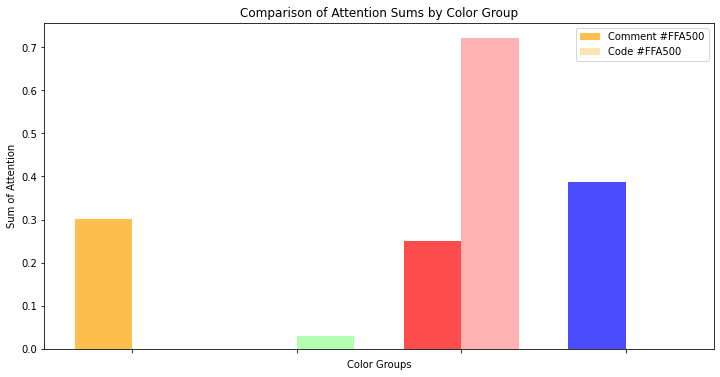

In [38]:
import matplotlib.pyplot as plt
# Calculate sum of attention by color groups
color_groups_comment = {}
color_groups_code = {}

# Group attentions by color for comments
for idx, color in color_map_comment.items():
    if color not in color_groups_comment:
        color_groups_comment[color] = []
    color_groups_comment[color].append(array[idx]*2.5)

# Group attentions by color for code
for idx, color in color_map_code.items():
    if color not in color_groups_code:
        color_groups_code[color] = []
    color_groups_code[color].append(code_attention_feature[idx])

# Calculate sums for each color group
comment_color_sums = {color: np.sum(attns) for color, attns in color_groups_comment.items()}
code_color_sums = {color: np.sum(attns) for color, attns in color_groups_code.items()}

# Print comparison with color blocks
print("Attention sums by color group:")
print("\nComment:")
for color, sum_val in comment_color_sums.items():
    print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")
    
print("\nCode:")
for color, sum_val in code_color_sums.items():
    print(f"\033[48;2;{int(color[1:3],16)};{int(color[3:5],16)};{int(color[5:7],16)}m  \033[0m {color}: {sum_val:.4f}")

# Plot comparison
plt.figure(figsize=(12,6))

colors = list(set(color_map_comment.values()) | set(color_map_code.values()))
x = np.arange(len(colors))
width = 0.35

comment_sums = [comment_color_sums.get(c, 0) for c in colors]
code_sums = [code_color_sums.get(c, 0) for c in colors]

# Use the same colors for both comment and code bars
for i, (c_sum, cd_sum, color) in enumerate(zip(comment_sums, code_sums, colors)):
    plt.bar(i - width/2, c_sum, width, color=color, alpha=0.7, label=f'Comment {color}' if i==0 else "")
    plt.bar(i + width/2, cd_sum, width, color=color, alpha=0.3, label=f'Code {color}' if i==0 else "")

plt.xlabel('Color Groups')
plt.ylabel('Sum of Attention')
plt.title('Comparison of Attention Sums by Color Group')

# Create colored rectangles for x-axis labels
ax = plt.gca()
ax.set_xticks(x)
ax.set_xticklabels([''] * len(colors))  # Clear text labels
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i-0.2, -0.1), 0.4, 0.05, color=color, transform=ax.transData))

plt.legend()
plt.show()


In [334]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import time

# # 读取高维向量 (num, 768)
# input_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_1/train_data.npy'
# data = np.load(input_path)

ENCODER_DIMS = [768,256,256,256,256,2]
DECODER_DIMS = [2,256,256,256,256,768]

CONTENT_PATH = '/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp'
EPOCH_START = 1
EPOCH_END = 1
EPOCH_PERIOD = 1
B_N_EPOCHS = 0
N_NEIGHBORS = 8
VIS_MODEL_NAME = 'dvi_aa'
LAMBDA1 = 1
S_N_EPOCHS = 5
PATIENT = 3
MAX_EPOCH = 10
GPU_ID = 3
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
net = "Model"
CLASSES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"]

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)

# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)

umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=1)
# Define Projector
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)

prev_model = VisModel(ENCODER_DIMS, DECODER_DIMS)
start_flag = 1

for iteration in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
    # Define DVI Loss
    if start_flag:
        temporal_loss_fn = DummyTemporalLoss(DEVICE)
        criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.0,device=DEVICE)
        start_flag = 0
    else:
        # TODO AL mode, redefine train_representation
        prev_data = data_provider.train_representation(iteration-EPOCH_PERIOD)
        prev_data = prev_data.reshape(prev_data.shape[0],prev_data.shape[1])
        curr_data = data_provider.train_representation(iteration)
        curr_data = curr_data.reshape(curr_data.shape[0],curr_data.shape[1])
        print(prev_data.shape, curr_data.shape)
        t_1= time.time()
        npr = torch.tensor(find_neighbor_preserving_rate(prev_data, curr_data, N_NEIGHBORS)).to(DEVICE)
        t_2= time.time()
     
        temporal_loss_fn = TemporalLoss(w_prev, DEVICE)
        criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=1, lambd2=0.1*npr,device=DEVICE)

    # Define training parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
    # Define Edge dataset

    t0 = time.time()
    ##### construct the spitial complex
    spatial_cons = SingleEpochTextSpatialEdgeConstructor(data_provider, iteration, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
    edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
    t1 = time.time()

    print('complex-construct:', t1-t0)

    probs = probs / (probs.max()+1e-3)
    eliminate_zeros = probs> 1e-3    #1e-3
    edge_to = edge_to[eliminate_zeros]
    edge_from = edge_from[eliminate_zeros]#     probs = probs[eliminate_zeros]
    
    labels_non_boundary = np.zeros(len(edge_to))

    # pred_list = data_provider.get_pred(iteration, feature_vectors)
    pred_list = np.zeros(feature_vectors.shape)
    dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, probs,pred_list)

    n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
    # chose sampler based on the number of dataset
    if len(edge_to) > pow(2,24):
        sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
    else:
        sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
    edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

    ########################################################################################################################
    #                                                       TRAIN                                                          #
    ########################################################################################################################

    trainer = BaseTextTrainer(model, criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)

    t2=time.time()
    trainer.train(PATIENT, MAX_EPOCH, data_provider,iteration)
    t3 = time.time()
    print('training:', t3-t2)
    # save result
    save_dir = data_provider.model_path
    trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "complex_construction", str(iteration), t1-t0)
    trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "training", str(iteration), t3-t2)
    save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(iteration))
    trainer.save(save_dir=save_dir, file_name="{}".format(VIS_MODEL_NAME))

    print("Finish epoch {}...".format(iteration))
 
    prev_model.load_state_dict(model.state_dict())
    for param in prev_model.parameters():
        param.requires_grad = False
    w_prev = dict(prev_model.named_parameters())


Finish initialization...


Thu Feb 13 13:49:01 2025 Building RP forest with 5 trees
Thu Feb 13 13:49:01 2025 NN descent for 6 iterations
	 1  /  6
	 2  /  6
	 3  /  6
	Stopping threshold met -- exiting after 3 iterations
complex-construct: 0.4825742244720459
epoch:1


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


umap:7.2372	recon_l:0.2471	new_loss:7.2372	loss:7.4844
epoch:2


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


umap:1.3844	recon_l:0.1888	new_loss:1.3844	loss:1.5732
epoch:3


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


umap:0.5657	recon_l:1.3121	new_loss:0.5657	loss:1.8778
epoch:4


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


umap:0.6611	recon_l:0.2014	new_loss:0.6611	loss:0.8626
epoch:5


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


umap:0.7616	recon_l:11.7402	new_loss:0.7616	loss:12.5019
epoch:6


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


umap:0.7046	recon_l:4.7146	new_loss:0.7046	loss:5.4192
epoch:7


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


umap:0.6809	recon_l:1.4721	new_loss:0.6809	loss:2.1530
epoch:8


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


umap:0.6975	recon_l:0.4621	new_loss:0.6975	loss:1.1595
epoch:9


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


umap:0.6706	recon_l:0.2217	new_loss:0.6706	loss:0.8923
epoch:10


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


umap:0.6808	recon_l:0.2121	new_loss:0.6808	loss:0.8929
Time spend: 13.07 for training vis model...
training: 13.069025993347168
Successfully save visualization model...
Finish epoch 1...


Successfully load the DVI visualization model for iteration 1
x_min: -8.985813772678375, x_max: 34.43498001098633, y_min: -15.618302631378175, y_max: 26.97861557006836


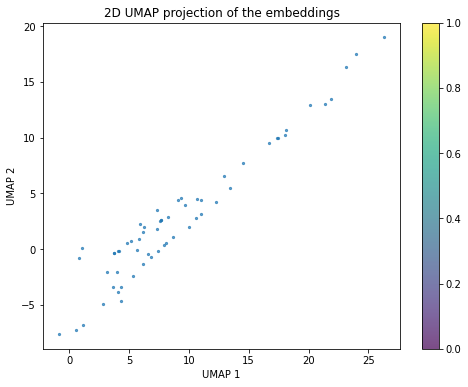

Scale saved to /home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_1/scale.npy
Embedding saved to /home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_1/embedding.npy


In [335]:
import matplotlib.pyplot as plt
for iteration in range(EPOCH_START, EPOCH_END+EPOCH_PERIOD, EPOCH_PERIOD):
    iter_data = data_provider.train_representation(iteration)
    embedding = projector.batch_project(iteration, iter_data)
    all_nodes_2d = embedding  # 使用你降维后的二维数据

    x_min, y_min = np.min(all_nodes_2d, axis=0)
    x_max, y_max = np.max(all_nodes_2d, axis=0)
    # ebd_extent = ebd_max - ebd_min
    x_extent = x_max - x_min
    y_extent = y_max - y_min

    x_min = x_min - 0.3 * x_extent
    x_max = x_max + 0.3 * x_extent
    y_min = y_min - 0.3 * y_extent
    y_max = y_max + 0.3 * y_extent

    # 打印结果
    print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

    # 将结果保存到指定文件夹
    save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(iteration))
    scale_path = os.path.join(save_dir, "scale.npy")
    np.save(scale_path, [x_min, y_min, x_max, y_max])

    # 保存embedding结果
    embedding_path = os.path.join(save_dir, "embedding.npy") 
    np.save(embedding_path, embedding)

    # 可视化 embedding 的二维散点图
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', alpha=0.7)
    plt.title('2D UMAP projection of the embeddings')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()
    plt.show()

    print(f"Scale saved to {scale_path}")
    print(f"Embedding saved to {embedding_path}")


In [336]:
for i in range(1, 2):
    source_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/Model/Epoch_{i}/embedding.npy'
    destination_file = f'/home/yiming/cophi/training_dynamic/gcb_tokens_visactor_temp/visualize/DVI/projection/{i}.npy'
    shutil.copyfile(source_file, destination_file)